<a href="https://colab.research.google.com/github/Nischith7102005/living-dataset/blob/main/mainfile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ======================  CELL-1  ======================
# 1. Bring in the tools we need
import numpy as np                # fast maths on lists of numbers
import pandas as pd               # spreadsheets in Python
from sklearn.datasets import load_iris   # built-in flower data (no internet!)
from sklearn.linear_model import LogisticRegression  # tiny classifier
from sklearn.model_selection import train_test_split # split data
from sklearn.metrics import accuracy_score           # % correct

In [2]:
# ======================  CELL-2  ======================
# 2. Load the Iris flowers (150 rows, 4 numbers + 1 name)
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)   # 4 numbers
y = pd.Series(iris.target_names[iris.target], name='species')  # flower name

In [3]:
# ======================  CELL-3  ======================
# 3. Split into train-set (120 flowers) and test-set (30 flowers)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42, stratify=y)

In [4]:
# ======================  CELL-4  ======================
# 4. A tiny “flower barcode” holder
class Flower:
    def __init__(self, numbers):
        self.numbers = np.array(numbers, dtype=float)  # the 4 measurements
        self.fitness = 0.0                             # how good it is

In [5]:
# ======================  CELL-5  ======================
# 5. Make new flowers by adding tiny noise
def mutate(flower, noise_size=0.05):
    noise = np.random.normal(loc=0.0, scale=noise_size, size=flower.numbers.shape)
    return Flower(flower.numbers + noise)

In [6]:
# ======================  CELL-6  ======================
# 6. Make a child by mixing two parent flowers
def crossover(flower1, flower2):
    alpha = np.random.rand()       # 0-1 coin-flip
    child_numbers = alpha * flower1.numbers + (1 - alpha) * flower2.numbers
    return Flower(child_numbers)

In [7]:
# ======================  CELL-7  ======================
# 7. Measure how good a flower is → train classifier, return accuracy
def score_flowers(flowers, model, X_train, y_train):
    # Build a matrix from all flower numbers
    X_pop = np.array([f.numbers for f in flowers])
    model.fit(X_pop, y_train)                # train on current population
    preds = model.predict(X_pop)             # predict on same population
    acc = accuracy_score(y_train, preds)     # % correct
    # Store fitness inside each flower
    for f in flowers:
        f.fitness = acc
    return acc

In [8]:
# ======================  CELL-8  ======================
# 8. The Evolution Loop (no classes, just a function)
def evolve_population(flowers, model, X_train, y_train, gens=5):
    for gen in range(gens):
        # 1. Score everyone
        best_acc = score_flowers(flowers, model, X_train, y_train)
        print(f"Gen {gen+1}: best accuracy = {best_acc:.3f}")

        # 2. Keep top 50 %
        flowers.sort(key=lambda f: f.fitness, reverse=True)
        survivors = flowers[:len(flowers)//2]

        # 3. Breed children to refill population
        children = []
        for _ in range(len(flowers) - len(survivors)):
            mom, dad = np.random.choice(survivors, 2, replace=False)
            child = crossover(mom, dad)
            child = mutate(child)
            children.append(child)

        # 4. Next generation
        flowers = survivors + children

    return flowers


In [9]:

# ======================  CELL-9  ======================
# 9. Create starting population (copies of real flowers)
starter_flowers = [Flower(row) for row in X_train.values]
model = LogisticRegression(max_iter=1000)

# Evolve for 5 generations
evolved_flowers = evolve_population(starter_flowers, model, X_train, y_train, gens=5)

Gen 1: best accuracy = 0.975
Gen 2: best accuracy = 0.675
Gen 3: best accuracy = 0.583
Gen 4: best accuracy = 0.617
Gen 5: best accuracy = 0.617


In [10]:
# ======================  CELL-10  ======================
# 10. Turn evolved flowers back into a pandas DataFrame
evolved_numbers = np.array([f.numbers for f in evolved_flowers])
evolved_df = pd.DataFrame(evolved_numbers, columns=X.columns)
evolved_df['species'] = y_train.values  # keep original labels
evolved_df.to_csv("evolved_iris.csv", index=False)
print("Saved evolved_iris.csv")

Saved evolved_iris.csv


In [11]:
# ======================  CELL-11  ======================
# 11. Train a NEW model on synthetic flowers, test on REAL unseen flowers
final_model = LogisticRegression(max_iter=1000)
final_model.fit(evolved_df.drop(columns='species'), evolved_df['species'])
pred = final_model.predict(X_test)
print("Accuracy on REAL unseen flowers:", accuracy_score(y_test, pred))

Accuracy on REAL unseen flowers: 0.8


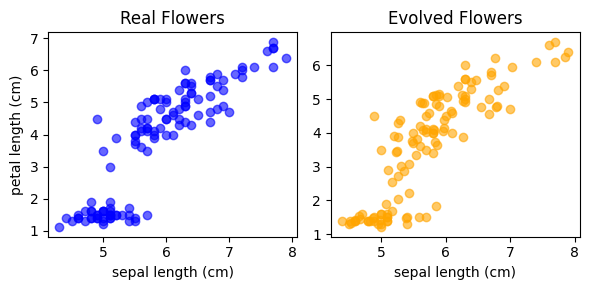

In [12]:
# ======================  CELL-12  ======================
import matplotlib.pyplot as plt

# pick two columns for an easy 2-D plot
COL_X, COL_Y = 'sepal length (cm)', 'petal length (cm)'

# original real flowers
orig_x = X_train[COL_X]
orig_y = X_train[COL_Y]

# evolved synthetic flowers
evol_x = evolved_df[COL_X]
evol_y = evolved_df[COL_Y]

plt.figure(figsize=(6, 3))

# left plot: real
plt.subplot(1, 2, 1)
plt.scatter(orig_x, orig_y, color='blue', alpha=0.6)
plt.title("Real Flowers")
plt.xlabel(COL_X)
plt.ylabel(COL_Y)

# right plot: evolved
plt.subplot(1, 2, 2)
plt.scatter(evol_x, evol_y, color='orange', alpha=0.6)
plt.title("Evolved Flowers")
plt.xlabel(COL_X)

plt.tight_layout()
plt.show()